In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 78 GB / percent used: 37.9 %


# GMTED2010 elevation data at different resolutions

http://www.temis.nl/data/gmted2010/

Test with the 2 lightest files:
- GMTED2010_15n240_1000deg.nc
- GMTED2010_15n120_0500deg.nc

In [141]:
GMTED2010_15n240_1000deg = xr.open_dataset('GMTED2010_15n240_1000deg.nc')
GMTED2010_15n240_1000deg

<xarray.Dataset>
Dimensions:           (nbounds: 2, nlat: 180, nlon: 360)
Coordinates:
  * nlat              (nlat) int16 0 1 2 3 4 5 6 ... 173 174 175 176 177 178 179
  * nlon              (nlon) int16 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * nbounds           (nbounds) int16 0 1
Data variables:
    latitude          (nlat) float32 ...
    longitude         (nlon) float32 ...
    latitude_bounds   (nlat, nbounds) float32 ...
    longitude_bounds  (nlon, nbounds) float32 ...
    elevation         (nlat, nlon) int16 ...
    elevation_stddev  (nlat, nlon) int16 ...
    elevation_max     (nlat, nlon) int16 ...
    elevation_min     (nlat, nlon) int16 ...
Attributes:
    Title:                      GMTED2010 elevation data regridded at 1.000 d...
    resolution_degrees:         1.0
    resolution_summing_factor:  240
    input_file:                 S5P_OPER_REF_DEM_15_00000000T000000_99999999T...
    input_correction:           incorrect zero elevation values in the Caspia...
    institution:                KNMI / TEMIS
    url:                        http://temis.nl/data/gmted2010/
    input_note:                 see "Original_attributes" for a copy of the a...
    history:                    2016-01-11: Conversion from HDF-5 by Maarten ...
    creation_date:              2016-02-29
    gmted2010_citation:         Danielson, J.J., and Gesch, D.B., 2011, Globa...
    gmted2010_viewer_url:       http://topotools.cr.usgs.gov/gmted_viewer/
    gmted2010_citation_url:     http://pubs.usgs.gov/of/2011/1073/pdf/of2011-...

In [142]:
GMTED2010_15n120_0500deg = xr.open_dataset('GMTED2010_15n120_0500deg.nc')
GMTED2010_15n120_0500deg

<xarray.Dataset>
Dimensions:           (nbounds: 2, nlat: 360, nlon: 720)
Coordinates:
  * nlat              (nlat) int16 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * nlon              (nlon) int16 0 1 2 3 4 5 6 ... 713 714 715 716 717 718 719
  * nbounds           (nbounds) int16 0 1
Data variables:
    latitude          (nlat) float32 ...
    longitude         (nlon) float32 ...
    latitude_bounds   (nlat, nbounds) float32 ...
    longitude_bounds  (nlon, nbounds) float32 ...
    elevation         (nlat, nlon) int16 ...
    elevation_stddev  (nlat, nlon) int16 ...
    elevation_max     (nlat, nlon) int16 ...
    elevation_min     (nlat, nlon) int16 ...
Attributes:
    Title:                      GMTED2010 elevation data regridded at 0.500 d...
    resolution_degrees:         0.5
    resolution_summing_factor:  120
    input_file:                 S5P_OPER_REF_DEM_15_00000000T000000_99999999T...
    input_correction:           incorrect zero elevation values in the Caspia...
    institution:                KNMI / TEMIS
    url:                        http://temis.nl/data/gmted2010/
    input_note:                 see "Original_attributes" for a copy of the a...
    history:                    2016-01-11: Conversion from HDF-5 by Maarten ...
    creation_date:              2016-02-29
    gmted2010_citation:         Danielson, J.J., and Gesch, D.B., 2011, Globa...
    gmted2010_viewer_url:       http://topotools.cr.usgs.gov/gmted_viewer/
    gmted2010_citation_url:     http://pubs.usgs.gov/of/2011/1073/pdf/of2011-...

In [143]:
# Put the lon and lat as dimensions for plots
GMTED2010_15n240_1000deg = GMTED2010_15n240_1000deg.swap_dims({'nlon': 'longitude', 'nlat': 'latitude'})
GMTED2010_15n120_0500deg = GMTED2010_15n120_0500deg.swap_dims({'nlon': 'longitude', 'nlat': 'latitude'})

# Rename lon lat for the regrid after
GMTED2010_15n240_1000deg = GMTED2010_15n240_1000deg.rename({'latitude': 'lat', 'longitude': 'lon'})
GMTED2010_15n120_0500deg = GMTED2010_15n120_0500deg.rename({'latitude': 'lat', 'longitude': 'lon'})

# Add the bounds format xESMF for conservative regrid
lat_b = xr.combine_nested([GMTED2010_15n240_1000deg.latitude_bounds[:,0], GMTED2010_15n240_1000deg.latitude_bounds[-1:,1]], concat_dim='lat').values
lon_b = xr.combine_nested([GMTED2010_15n240_1000deg.longitude_bounds[:,0], GMTED2010_15n240_1000deg.longitude_bounds[-1:,1]], concat_dim='lon').values
GMTED2010_15n240_1000deg = GMTED2010_15n240_1000deg.assign_coords({'lat_b': lat_b, 'lon_b': lon_b})

lat_b = xr.combine_nested([GMTED2010_15n120_0500deg.latitude_bounds[:,0], GMTED2010_15n120_0500deg.latitude_bounds[-1:,1]], concat_dim='lat').values
lon_b = xr.combine_nested([GMTED2010_15n120_0500deg.longitude_bounds[:,0], GMTED2010_15n120_0500deg.longitude_bounds[-1:,1]], concat_dim='lon').values
GMTED2010_15n120_0500deg = GMTED2010_15n120_0500deg.assign_coords({'lat_b': lat_b, 'lon_b': lon_b})

# Drop the nbounds dimension (bother for the regrid)
GMTED2010_15n240_1000deg = GMTED2010_15n240_1000deg.drop_dims('nbounds')
GMTED2010_15n120_0500deg = GMTED2010_15n120_0500deg.drop_dims('nbounds')

In [144]:
GMTED2010_15n120_0500deg

<xarray.Dataset>
Dimensions:           (lat: 360, lat_b: 361, lon: 720, lon_b: 721)
Coordinates:
    nlat              (lat) int16 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    nlon              (lon) int16 0 1 2 3 4 5 6 ... 713 714 715 716 717 718 719
  * lat               (lat) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon               (lon) float32 -179.75 -179.25 -178.75 ... 179.25 179.75
  * lat_b             (lat_b) float32 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * lon_b             (lon_b) float32 -180.0 -179.5 -179.0 ... 179.0 179.5 180.0
Data variables:
    elevation         (lat, lon) int16 ...
    elevation_stddev  (lat, lon) int16 ...
    elevation_max     (lat, lon) int16 ...
    elevation_min     (lat, lon) int16 ...
Attributes:
    Title:                      GMTED2010 elevation data regridded at 0.500 d...
    resolution_degrees:         0.5
    resolution_summing_factor:  120
    input_file:                 S5P_OPER_REF_DEM_15_00000000T000000_99999999T...
    input_correction:           incorrect zero elevation values in the Caspia...
    institution:                KNMI / TEMIS
    url:                        http://temis.nl/data/gmted2010/
    input_note:                 see "Original_attributes" for a copy of the a...
    history:                    2016-01-11: Conversion from HDF-5 by Maarten ...
    creation_date:              2016-02-29
    gmted2010_citation:         Danielson, J.J., and Gesch, D.B., 2011, Globa...
    gmted2010_viewer_url:       http://topotools.cr.usgs.gov/gmted_viewer/
    gmted2010_citation_url:     http://pubs.usgs.gov/of/2011/1073/pdf/of2011-...

In [157]:
GMTED2010_15n240_1000deg

<xarray.Dataset>
Dimensions:           (lat: 180, lat_b: 181, lon: 360, lon_b: 361)
Coordinates:
    nlat              (lat) int16 0 1 2 3 4 5 6 ... 173 174 175 176 177 178 179
    nlon              (lon) int16 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * lat               (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon               (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat_b             (lat_b) float32 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * lon_b             (lon_b) float32 -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
Data variables:
    elevation         (lat, lon) int16 2888 2886 2883 2881 2878 ... 0 0 0 0 0
    elevation_stddev  (lat, lon) int16 ...
    elevation_max     (lat, lon) int16 ...
    elevation_min     (lat, lon) int16 ...
Attributes:
    Title:                      GMTED2010 elevation data regridded at 1.000 d...
    resolution_degrees:         1.0
    resolution_summing_factor:  240
    input_file:                 S5P_OPER_REF_DEM_15_00000000T000000_99999999T...
    input_correction:           incorrect zero elevation values in the Caspia...
    institution:                KNMI / TEMIS
    url:                        http://temis.nl/data/gmted2010/
    input_note:                 see "Original_attributes" for a copy of the a...
    history:                    2016-01-11: Conversion from HDF-5 by Maarten ...
    creation_date:              2016-02-29
    gmted2010_citation:         Danielson, J.J., and Gesch, D.B., 2011, Globa...
    gmted2010_viewer_url:       http://topotools.cr.usgs.gov/gmted_viewer/
    gmted2010_citation_url:     http://pubs.usgs.gov/of/2011/1073/pdf/of2011-...

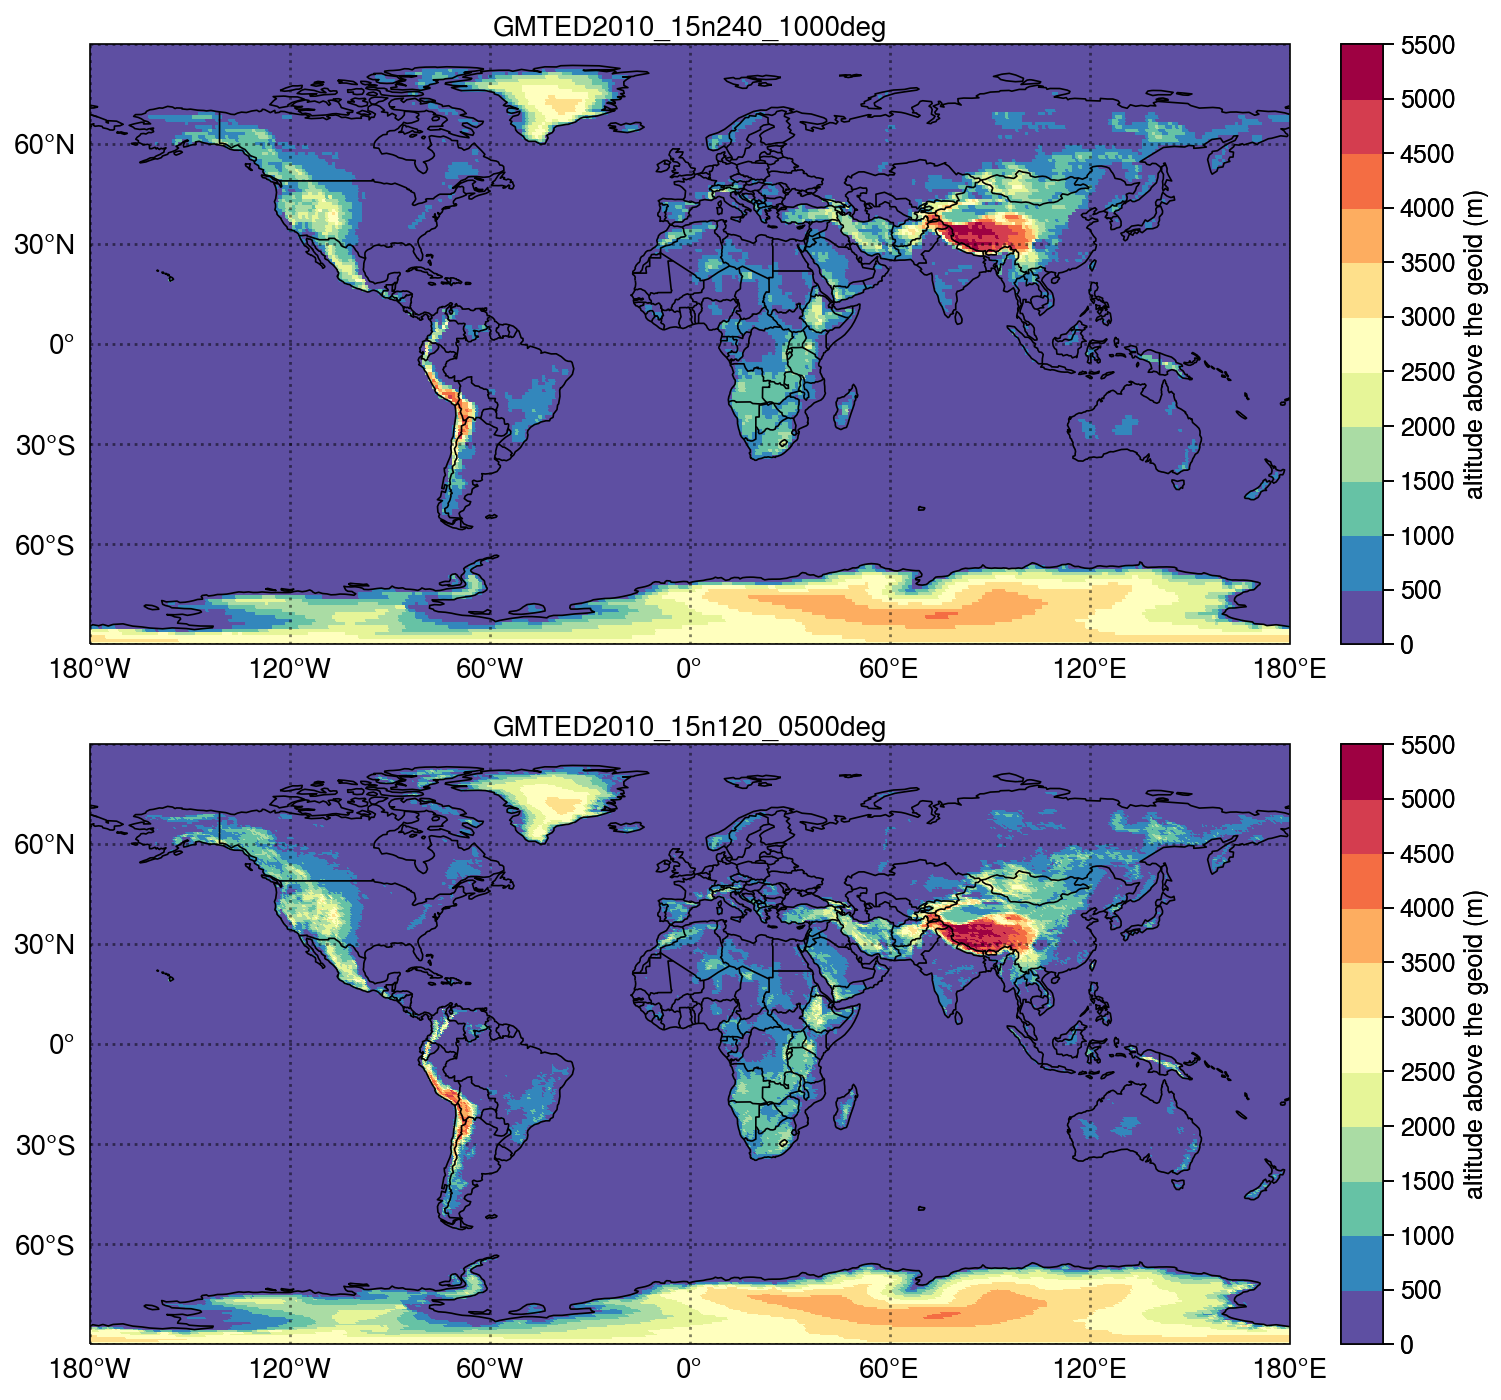

In [150]:
f, axs = plot.subplots(proj='cyl', ncols=1, nrows=2, axwidth=6)
levels = plot.arange(0,5500,500)

axs[0].pcolormesh(GMTED2010_15n240_1000deg.elevation, cmap='Spectral', levels=levels, colorbar='r')
axs[0].format(title='GMTED2010_15n240_1000deg')

axs[1].pcolormesh(GMTED2010_15n120_0500deg.elevation, cmap='Spectral', levels=levels, colorbar='r')
axs[1].format(title='GMTED2010_15n120_0500deg')

axs.format(labels=True, coast=True, borders=True, lonlines=60, latlines=30)

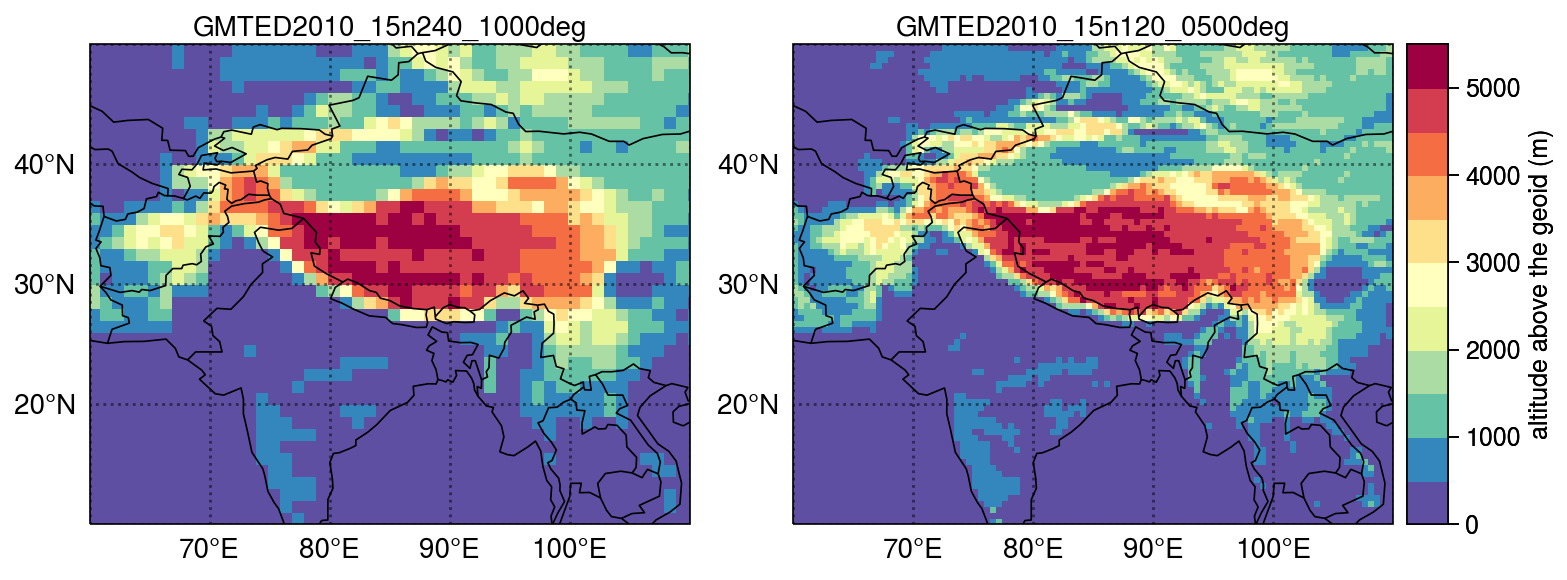

In [151]:
f, axs = plot.subplots(proj='cyl', ncols=2, nrows=1, axwidth=3)

levels = plot.arange(0,5500,500)

axs[0].pcolormesh(GMTED2010_15n240_1000deg.elevation, cmap='Spectral', levels=levels, colorbar=None)
axs[0].format(title='GMTED2010_15n240_1000deg')

axs[1].pcolormesh(GMTED2010_15n120_0500deg.elevation, cmap='Spectral', levels=levels, colorbar='r')
axs[1].format(title='GMTED2010_15n120_0500deg')

axs.format(labels=True, coast=True, borders=True, lonlines=10, latlines=10, latlim=(10,50), lonlim=(60,110))

# Try to regrid to see what is the best (bilinear, conservative, other?)

In [152]:
regridder_bil = xe.Regridder(GMTED2010_15n120_0500deg, GMTED2010_15n240_1000deg, 'bilinear', periodic=True, reuse_weights=True)
regridder_bil

Create weight file: bilinear_360x720_180x360_peri.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_360x720_180x360_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (360, 720) 
Output grid shape:          (180, 360) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

lon_b and lat_b needs to be only 1D with n+1 dimensions... either we rebuild it, either we can use directly the util from xESMF `xe.util.grid_global(d_lon=0.5, d_lat=0.5)` (https://xesmf.readthedocs.io/en/latest/user_api.html?highlight=util#xesmf.util.grid_global)

Finally I made it at the beginning, the xESMF grid was not suiting

-> period not used for conservative

In [153]:
regridder_cons = xe.Regridder(GMTED2010_15n120_0500deg, GMTED2010_15n240_1000deg, 'conservative', reuse_weights=True)
regridder_cons

Create weight file: conservative_360x720_180x360.nc


xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_360x720_180x360.nc 
Reuse pre-computed weights? True 
Input grid shape:           (360, 720) 
Output grid shape:          (180, 360) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

Needs to remove `nbounds` dimension because xESMF takes the last 2 dimensions

In [154]:
GMTED2010_15n120_0500deg_regrid_bil = regridder_bil(GMTED2010_15n120_0500deg)
GMTED2010_15n120_0500deg_regrid_bil

using dimensions ('lat', 'lon') from data variable elevation as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:           (lat: 180, lat_b: 361, lon: 360, lon_b: 721)
Coordinates:
  * lat_b             (lat_b) float32 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * lon_b             (lon_b) float32 -180.0 -179.5 -179.0 ... 179.0 179.5 180.0
  * lon               (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat               (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    elevation         (lat, lon) float64 2.888e+03 2.886e+03 ... 0.0 0.0
    elevation_stddev  (lat, lon) float64 41.5 40.5 40.25 39.5 ... 0.0 0.0 0.0
    elevation_max     (lat, lon) float64 2.957e+03 2.954e+03 ... 0.0 0.0
    elevation_min     (lat, lon) float64 2.835e+03 2.834e+03 ... 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [155]:
GMTED2010_15n120_0500deg_regrid_cons = regridder_cons(GMTED2010_15n120_0500deg)
GMTED2010_15n120_0500deg_regrid_cons

using dimensions ('lat', 'lon') from data variable elevation as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:           (lat: 180, lat_b: 361, lon: 360, lon_b: 721)
Coordinates:
  * lat_b             (lat_b) float32 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * lon_b             (lon_b) float32 -180.0 -179.5 -179.0 ... 179.0 179.5 180.0
  * lon               (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat               (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    elevation         (lat, lon) float64 2.921e+03 2.918e+03 ... 0.0 0.0
    elevation_stddev  (lat, lon) float64 39.25 38.25 38.13 37.25 ... 0.0 0.0 0.0
    elevation_max     (lat, lon) float64 2.986e+03 2.983e+03 ... 0.0 0.0
    elevation_min     (lat, lon) float64 2.868e+03 2.866e+03 ... 0.0 0.0
Attributes:
    regrid_method:  conservative

# Check results

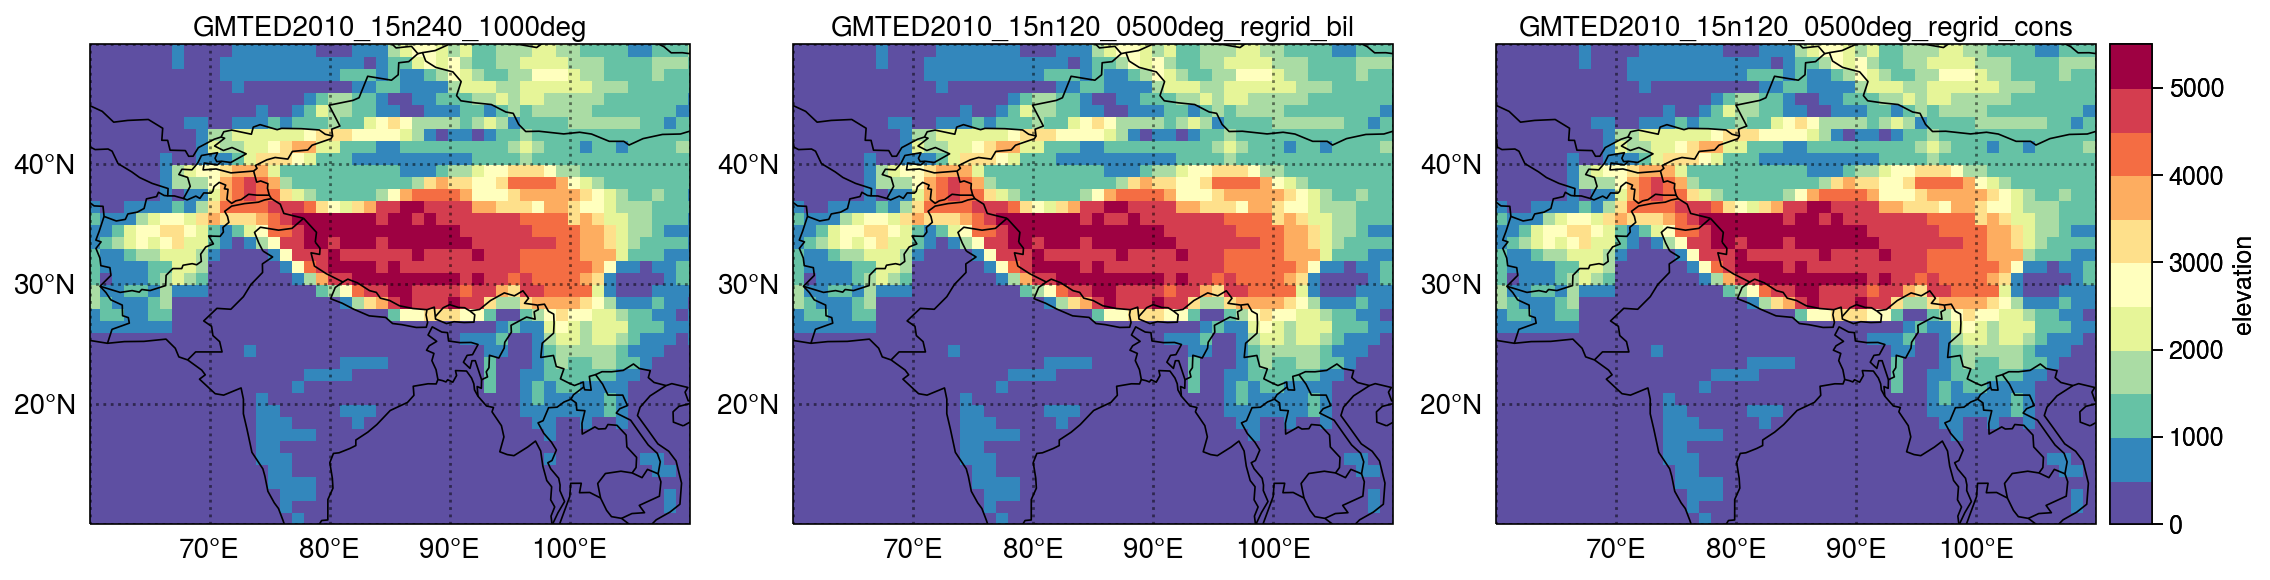

In [161]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=1, axwidth=3)

levels = plot.arange(0,5500,500)

axs[0].pcolormesh(GMTED2010_15n240_1000deg.elevation, cmap='Spectral', levels=levels, colorbar=None)
axs[0].format(title='GMTED2010_15n240_1000deg')

axs[1].pcolormesh(GMTED2010_15n120_0500deg_regrid_bil.elevation, cmap='Spectral', levels=levels, colorbar=None)
axs[1].format(title='GMTED2010_15n120_0500deg_regrid_bil')

axs[2].pcolormesh(GMTED2010_15n120_0500deg_regrid_cons.elevation, cmap='Spectral', levels=levels, colorbar='r')
axs[2].format(title='GMTED2010_15n120_0500deg_regrid_cons')

axs.format(labels=True, coast=True, borders=True, lonlines=10, latlines=10, latlim=(10,50), lonlim=(60,110))

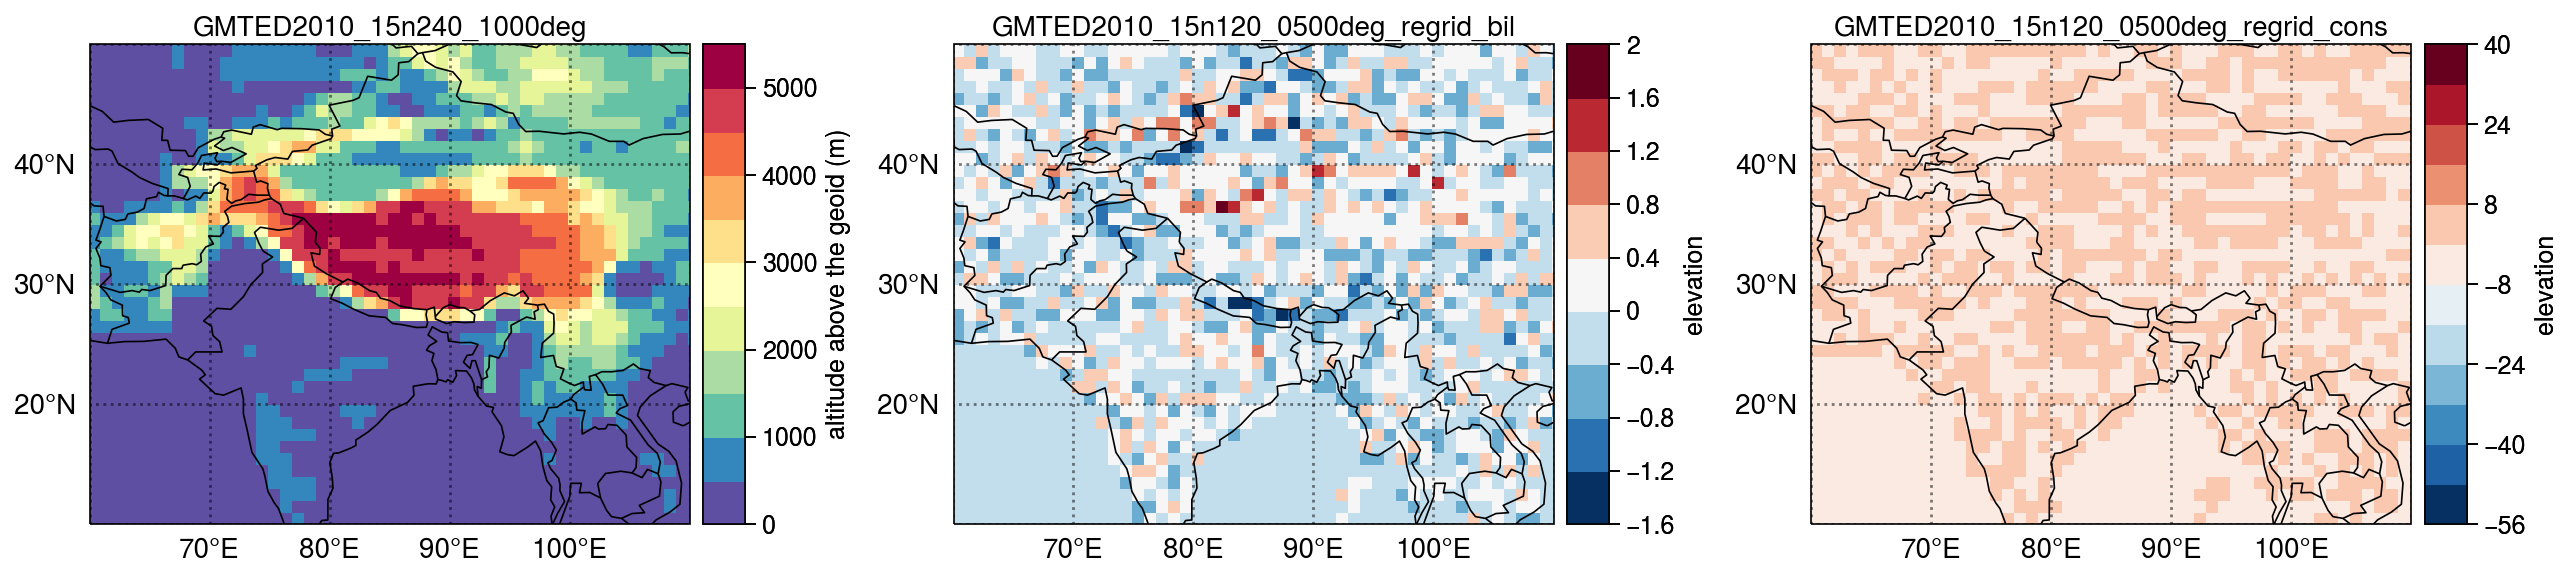

In [162]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=1, axwidth=3)

levels = plot.arange(0,5500,500)

axs[0].pcolormesh(GMTED2010_15n240_1000deg.elevation, cmap='Spectral', levels=levels, colorbar='r')
axs[0].format(title='GMTED2010_15n240_1000deg')

axs[1].pcolormesh(
    GMTED2010_15n120_0500deg_regrid_bil.elevation-GMTED2010_15n240_1000deg.elevation, 
    cmap='BuRd', 
#     levels=levels, 
    colorbar='r'
)
axs[1].format(title='GMTED2010_15n120_0500deg_regrid_bil')

axs[2].pcolormesh(
    GMTED2010_15n120_0500deg_regrid_cons.elevation-GMTED2010_15n240_1000deg.elevation, 
    cmap='BuRd', 
#     levels=levels, 
    colorbar='r'
)
axs[2].format(title='GMTED2010_15n120_0500deg_regrid_cons')

axs.format(labels=True, coast=True, borders=True, lonlines=10, latlines=10, latlim=(10,50), lonlim=(60,110))

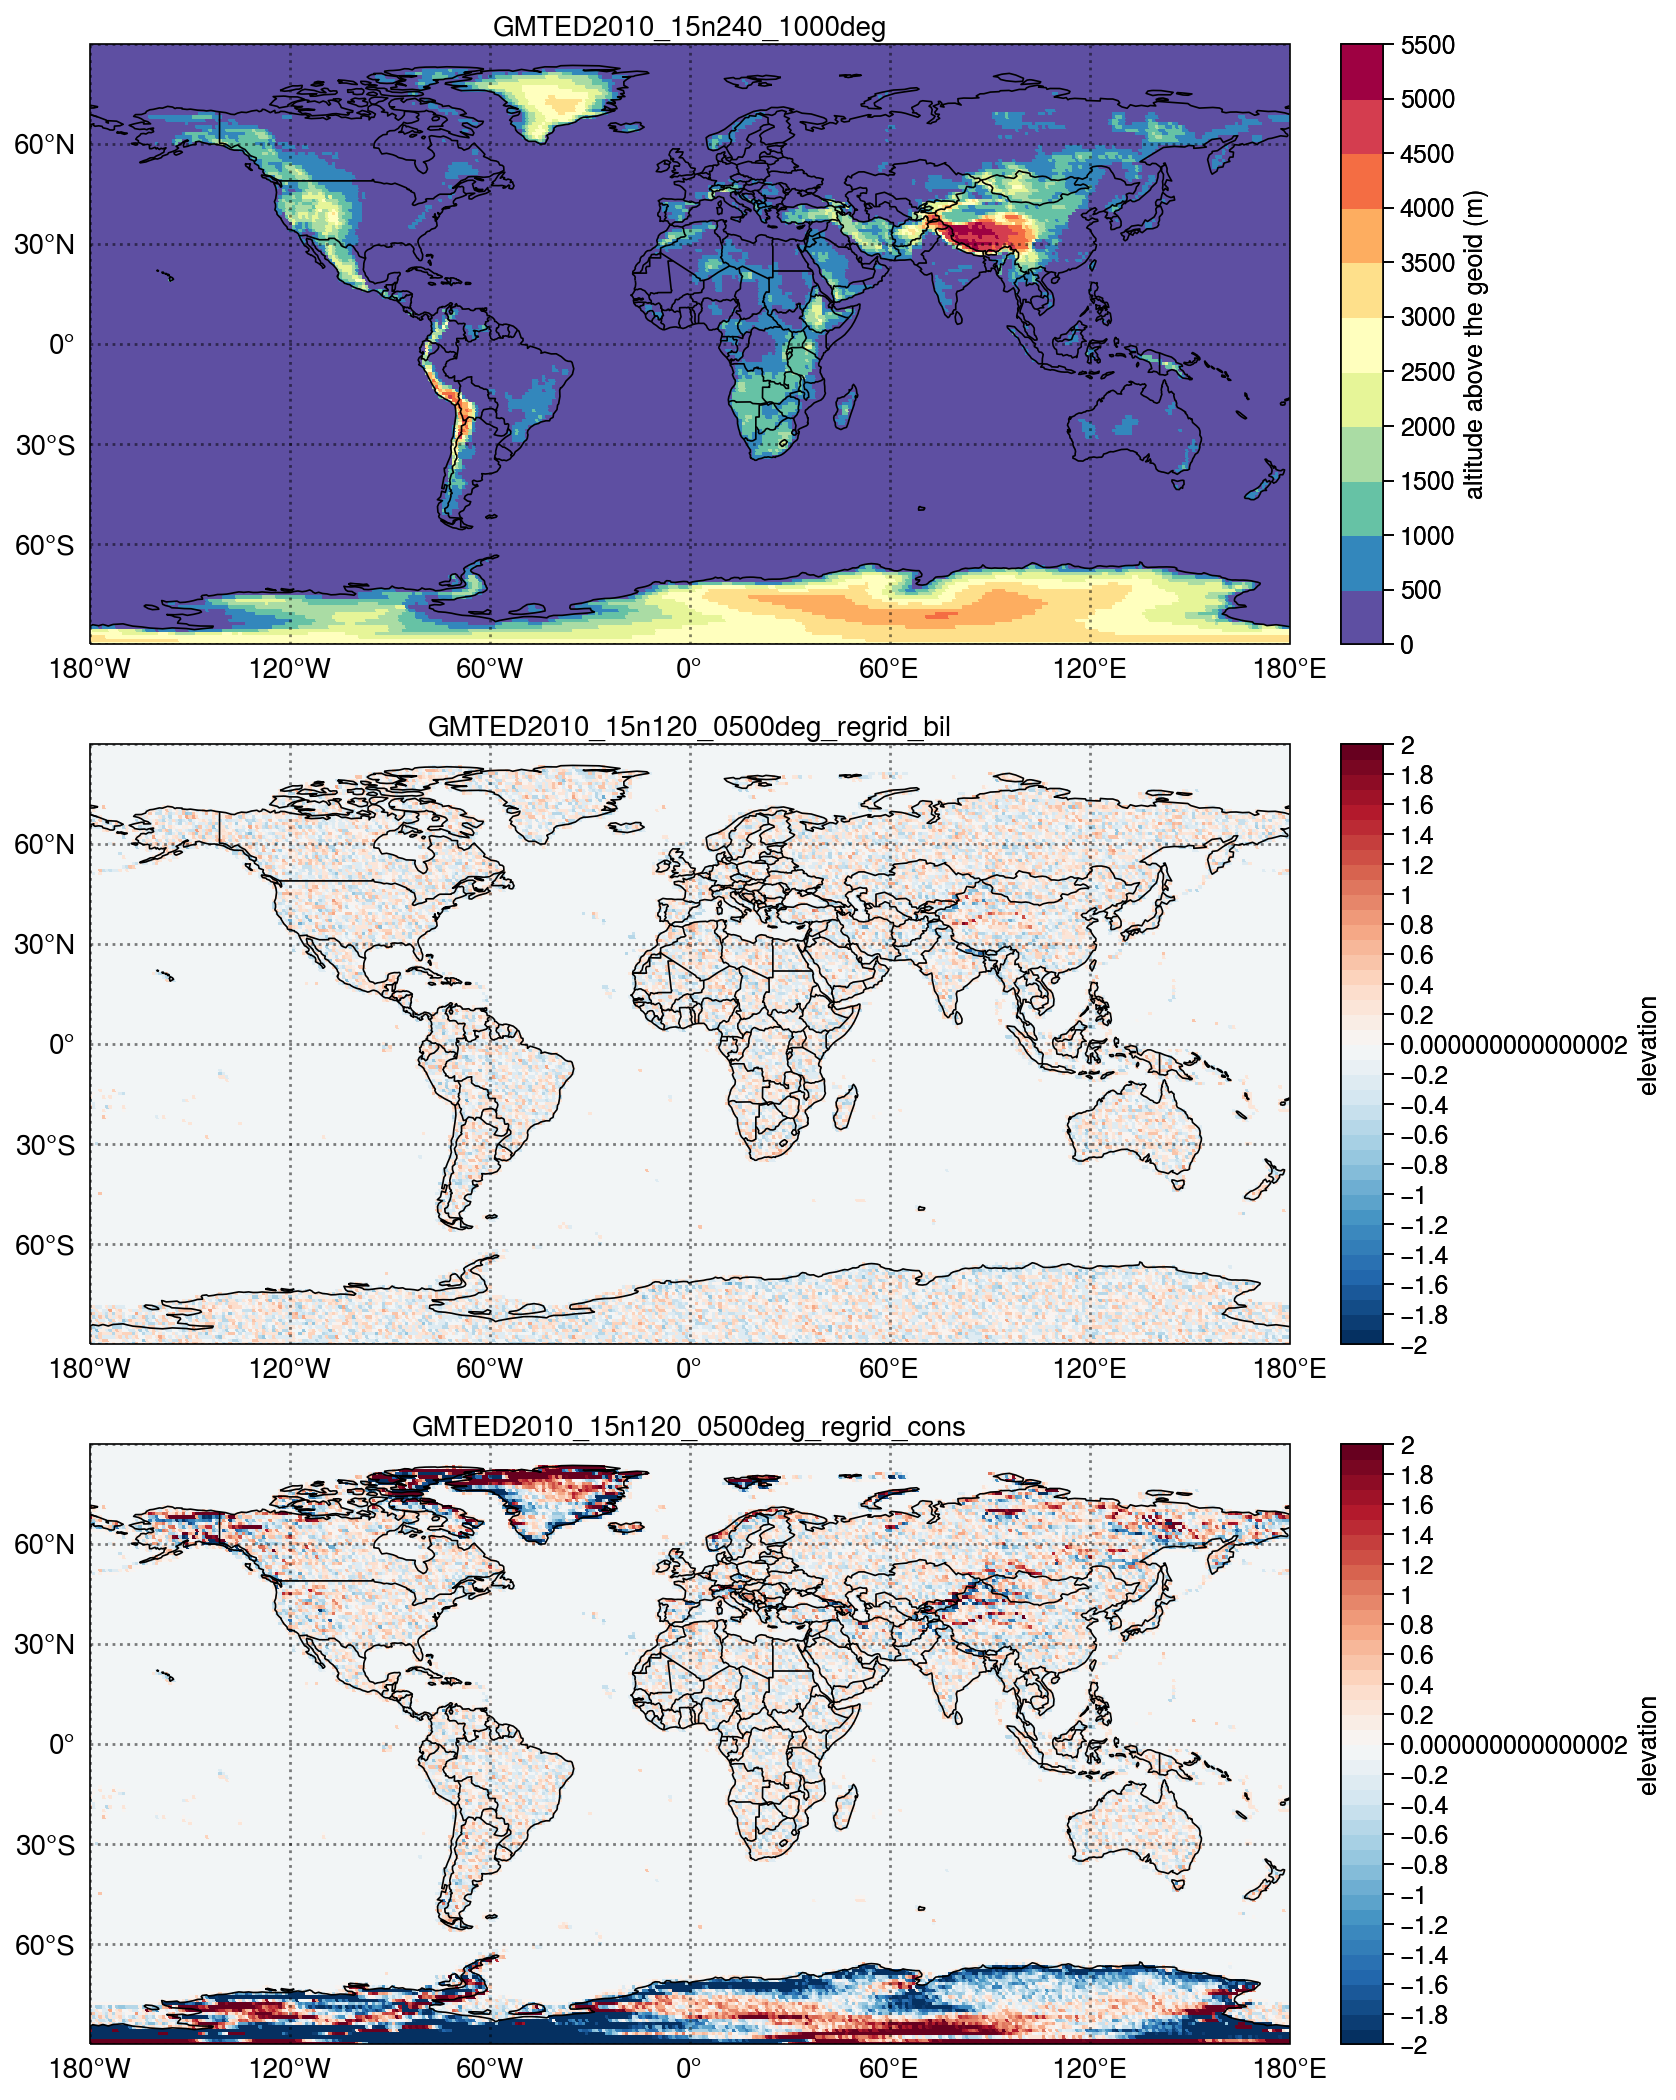

In [165]:
f, axs = plot.subplots(proj='cyl', ncols=1, nrows=3, axwidth=6)

levels = plot.arange(0,5500,500)

axs[0].pcolormesh(GMTED2010_15n240_1000deg.elevation, cmap='Spectral', levels=levels, colorbar='r')
axs[0].format(title='GMTED2010_15n240_1000deg')

axs[1].pcolormesh(
    GMTED2010_15n120_0500deg_regrid_bil.elevation-GMTED2010_15n240_1000deg.elevation, 
    cmap='BuRd', 
    levels=plot.arange(-2,2,0.1), 
    colorbar='r'
)
axs[1].format(title='GMTED2010_15n120_0500deg_regrid_bil')

axs[2].pcolormesh(
    GMTED2010_15n120_0500deg_regrid_cons.elevation-GMTED2010_15n240_1000deg.elevation, 
    cmap='BuRd', 
    levels=plot.arange(-2,2,0.1), 
    colorbar='r'
)
axs[2].format(title='GMTED2010_15n120_0500deg_regrid_cons')

axs.format(labels=True, coast=True, borders=True, lonlines=60, latlines=30)